# **Data Visualisation**

## Objectives

1. Find the average size of images and generate a file containing the new image size data.
2. Calculate and visually represent the average variability of the dataset for each label.
3. Evaluate the distinction in average images between the "eyes open" and "eyes closed" labels.
4. Create image montages for both "eyes open" and "eyes closed" labels.

## Inputs

* Use the awareness dataset, which comprises of .jpg files organized into three folders.
  * File paths for the folders are:
    - inputs/awareness/test
    - inputs/awareness/train
    - inputs/awareness/validation

## Outputs

* Determine the computed average image size for the train set.
* Generate a .pkl file containing the preferred image sizes used for model fitting.
* Plot the mean and variability of images per label.
* Visualize the difference between "eyes open" and "eyes closed" images.
* Produce an image montage of .png files suitable for integration into the dashboard.


---

## Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import tensorflow as tf
sns.set_style("white")
from matplotlib.image import imread

2023-12-29 17:11:38.021383: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/PP5-Driver-Awareness-Detector/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/PP5-Driver-Awareness-Detector'

---

##  Set the Input Directories

Assign the input directories to variables to be used

In [6]:
my_data_dir = 'inputs/awareness'

# add extension for each folder
train_data = my_data_dir + '/train' 
validation_data = my_data_dir + '/validation'
test_data = my_data_dir + '/test'

---

##  Set the Output Directories

Assign the path for the output

In [11]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print(f'Version already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Version already available create a new version.


---

##  Set the label names

In [17]:
labels = os.listdir(train_data)
print('Image labels to be used are:', labels)

Image labels to be used are: ['eyes_closed', 'eyes_open']


---

#  Visualisation of the Image Data

### Calculate the Average Image size using the Train dataset

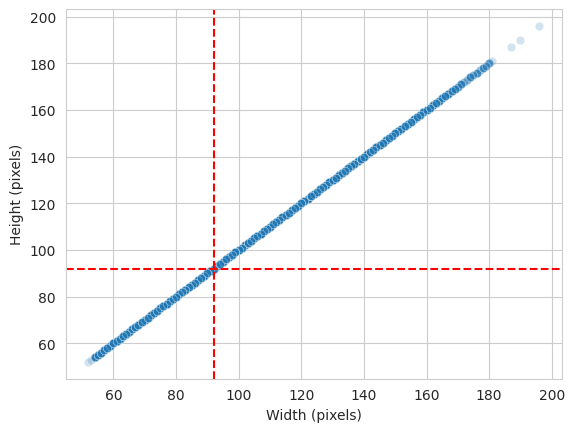

Width average: 92 
Height average: 92


In [39]:
dim1, dim2 = [], []
for label in labels:
    for image_filename in os.listdir(train_data + '/' + label):
        img = imread(train_data + '/' + label + '/' + image_filename)
        shape = img.shape
        if len(shape) == 2:
            # Grayscale image
            d1, d2 = shape
        else:
            # Colour Images
            d1, d2, colors = shape 
        dim1.append(d1)
        dim2.append(d2)

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean().round())
dim2_mean = int(np.array(dim2).mean().round())
axes.axvline(x=dim2_mean, color='r', linestyle='--')
axes.axhline(y=dim1_mean, color='r', linestyle='--')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")


Image size to be used for training the model is the average from the train dataset

In [40]:
image_shape = (dim1_mean, dim2_mean, 3)
image_shape

(92, 92, 3)

Save the image shape embeddings

In [41]:
joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape.pkl")

['outputs/v1/image_shape.pkl']

---

## Plot Variabilty of Images

### Function to load images in a tensor array

In [36]:
from tensorflow.keras.preprocessing import image

def load_image_as_array(my_data_dir, new_size=(50,50), n_images_per_label = 20):
  
  X, y = np.array([], dtype='int'), np.array([], dtype='object')
  labels = os.listdir(my_data_dir)

  for label in labels:
    counter = 0
    for image_filename in os.listdir(my_data_dir + '/' + label):
      # n_images_per_label: we set a limit, since it may take too much time
      if counter < n_images_per_label:
        
        img = image.load_img(my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
        if image.img_to_array(img).max() > 1: 
          img_resized = image.img_to_array(img) / 255
        else: 
          img_resized = image.img_to_array(img)
        
        X = np.append(X, img_resized).reshape(-1, new_size[0], new_size[1], img_resized.shape[2])
        y = np.append(y, label)
        counter += 1

  return X, y

## Load image and labels in array

In [37]:
X, y = load_image_as_array(my_data_dir=train_data,
                           new_size=image_shape,
                           n_images_per_label=30)
print(X.shape, y.shape)

(60, 92, 92, 3) (60,)


## Plot and save mean and variability of images per label

==== Label eyes_closed ====
Image Shape: (92, 92, 3)
==== Label eyes_open ====
Image Shape: (92, 92, 3)


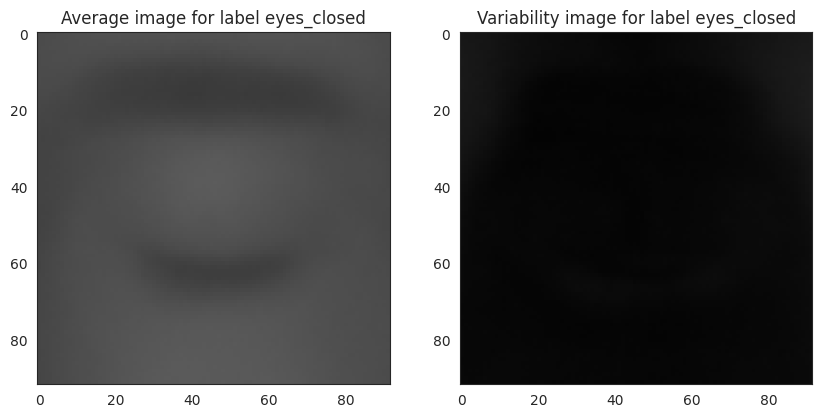

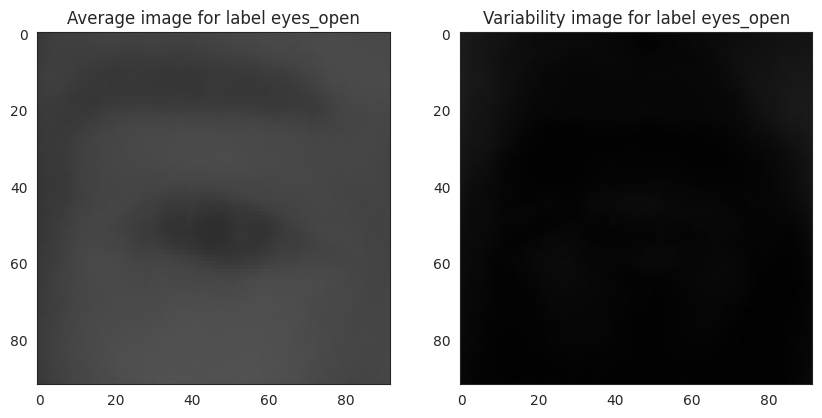

In [38]:
def plot_mean_variability_per_labels(X, y, figsize=(8, 5), save_image=False):
    """
    The pseudo-code for the function is:
    * Loop over all labels
    * Subset an array for a given label
    * Calculate the mean and standard deviation
    * Create a figure displaying the mean and variability of images
    * Save the image
    """

    for label_to_display in np.unique(y):
        sns.set_style("white")

        y = y.reshape(-1, 1, 1)
        boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
        arr = X[boolean_mask]

        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        print(f"==== Label {label_to_display} ====")
        print(f"Image Shape: {avg_img.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average image for label {label_to_display}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variability image for label {label_to_display}")
        axes[1].imshow(std_img, cmap='gray')

        if save_image:
            plt.savefig(f"{file_path}/avg_var_{label_to_display}.png",
                        bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()
            print("\n")

plot_mean_variability_per_labels(X=X, y=y, figsize=(10, 5), save_image=True)


---